In [127]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from xgboost import XGBRegressor

import sys, path, os

from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()

plt.style.use('fivethirtyeight')

In [28]:
# !pip install path
# os.getcwd()

In [102]:
df = pd.read_csv("../datasets/COMED_hourly.csv")
df.head()

,Datetime,COMED_MW
0,2011-12-31 01:00:00,9970.0
1,2011-12-31 02:00:00,9428.0
2,2011-12-31 03:00:00,9059.0
3,2011-12-31 04:00:00,8817.0
4,2011-12-31 05:00:00,8743.0


In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66497 entries, 0 to 66496
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Datetime  66497 non-null  object 
 1   COMED_MW  66497 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.0+ MB


In [104]:
# convert str to datetime
df.Datetime = pd.to_datetime(df.Datetime)
df.Datetime.max(), df.Datetime.min()

(Timestamp('2018-08-03 00:00:00'), Timestamp('2011-01-01 01:00:00'))

In [105]:
# set Datetime to index
df = df.set_index('Datetime')
df = df.sort_index()
df.head()

,COMED_MW
Datetime,
2011-01-01 01:00:00,9631.0
2011-01-01 02:00:00,9273.0
2011-01-01 03:00:00,9011.0
2011-01-01 04:00:00,8741.0
2011-01-01 05:00:00,8694.0


In [106]:
def plot_data(df):
    """function to plot the single data"""
    df.plot(style = '.', 
            figsize = (15,6), 
            color = color_pal[0],
            title = 'Comed Engery Use in MW'
           )
    plt.show()
    
def plot_train_test_data(train, test):
    """function to plot train and test split"""
    fig, ax = plt.subplots(figsize = (15,5))
    train.plot(ax=ax, label = 'Training', title = 'Train/Test Split')
    test.plot(ax=ax, label = 'Testing')
    ax.axvline('2016-01-01', color = 'black', ls='--')
    ax.legend(['Training set', 'Test set'], loc = 'upper right')
    plt.show()

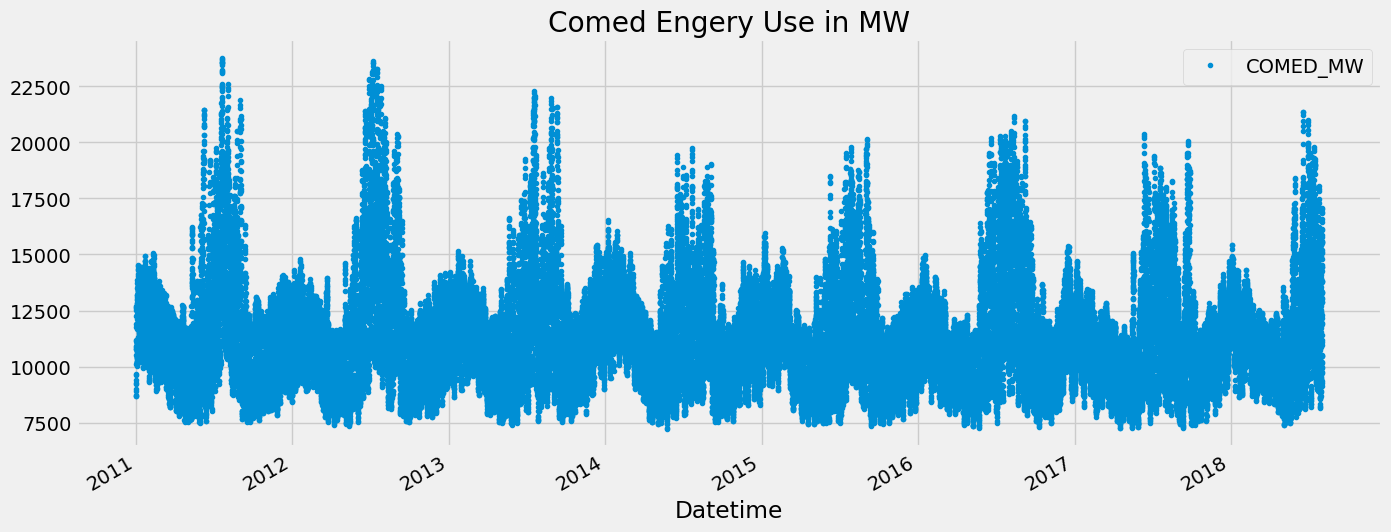

In [107]:
plot_data(df)

## Train Test Split

In [108]:
train = df.iloc[df.index < '2016-01-01']
test = df.iloc[df.index >= '2016-01-01']
print(train.shape, test.shape)

(43817, 1) (22680, 1)


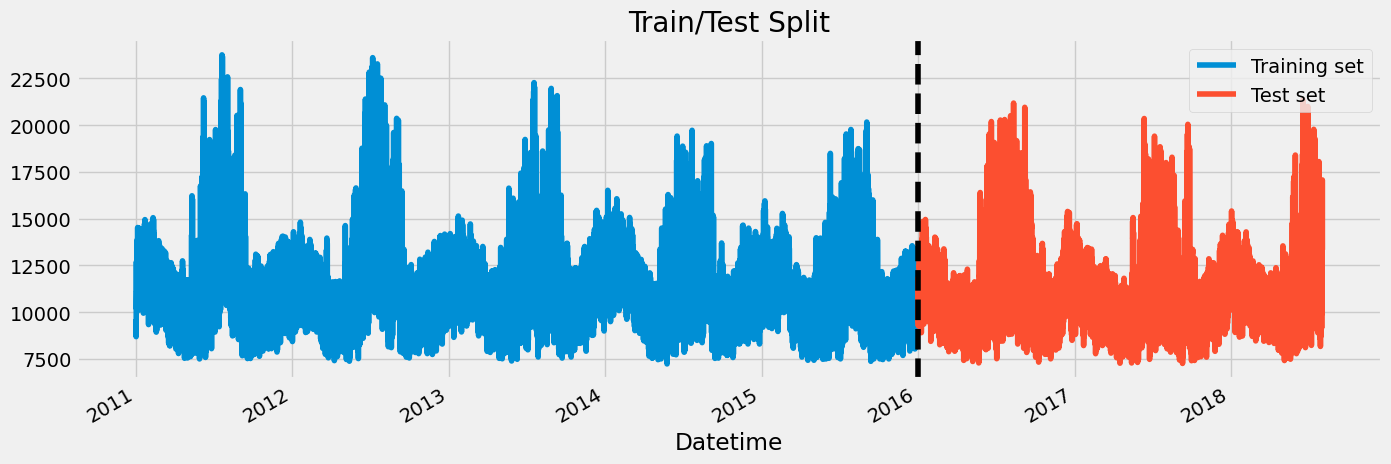

In [109]:
plot_train_test_data(train,test)

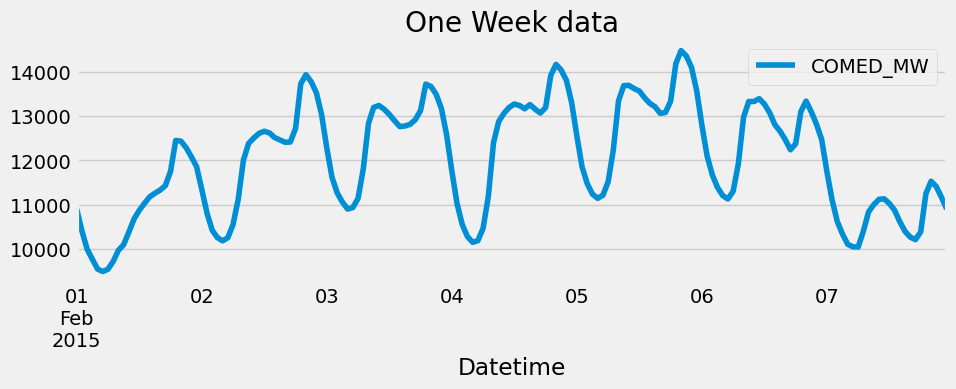

In [112]:
# plot the one week data to check if there is a trend
df.loc[(df.index>='2015-02-01')&(df.index<'2015-02-08')].plot(figsize = (10,3), title = 'One Week data')
plt.show()

## Feature Creation

In [113]:
def create_new_features(df):
    """function to generate new features based on existing features"""
    df = df.copy()
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['week_of_year'] = df.index.isocalendar().week
    df['day_of_year'] = df.index.day_of_week
    df['day_of_month'] = df.index.day
    df['day_of_week'] = df.index.dayofweek
    df['hour'] = df.index.hour
    return df

In [115]:
df_new = create_new_features(df)
df_new.head()

,COMED_MW,year,month,week_of_year,day_of_year,day_of_month,day_of_week,hour
Datetime,,,,,,,,
2011-01-01 01:00:00,9631.0,2011,1,52,5,1,5,1
2011-01-01 02:00:00,9273.0,2011,1,52,5,1,5,2
2011-01-01 03:00:00,9011.0,2011,1,52,5,1,5,3
2011-01-01 04:00:00,8741.0,2011,1,52,5,1,5,4
2011-01-01 05:00:00,8694.0,2011,1,52,5,1,5,5


## Plot the new features using box plot

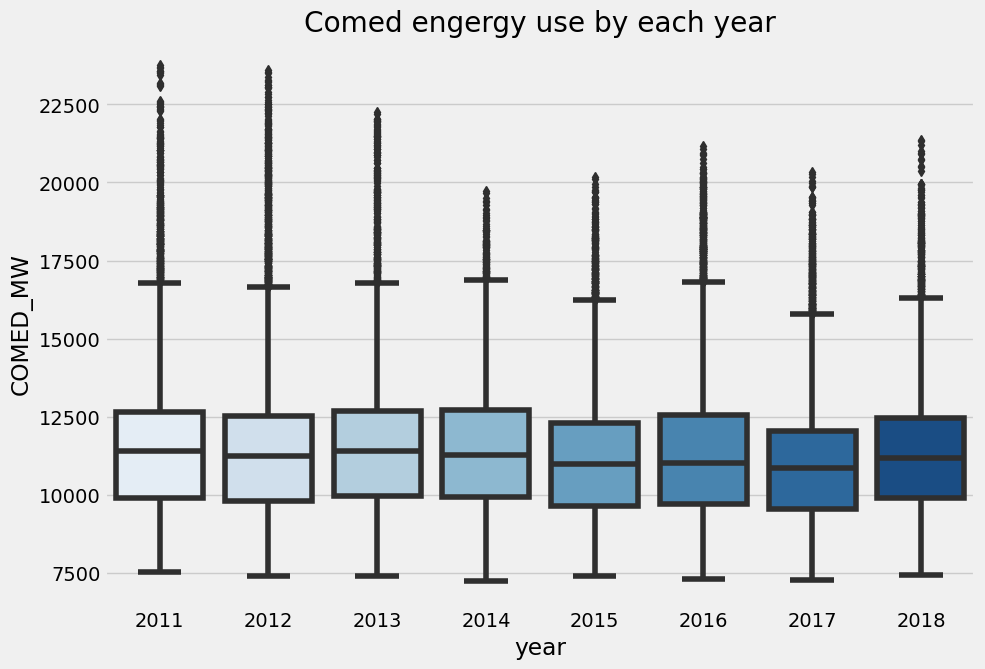

In [123]:
fig, ax = plt.subplots(figsize = (10,7))
sns.boxplot(data = df_new, x = 'year', y = 'COMED_MW', palette='Blues')
ax.set_title('Comed engergy use by each year')
plt.show()

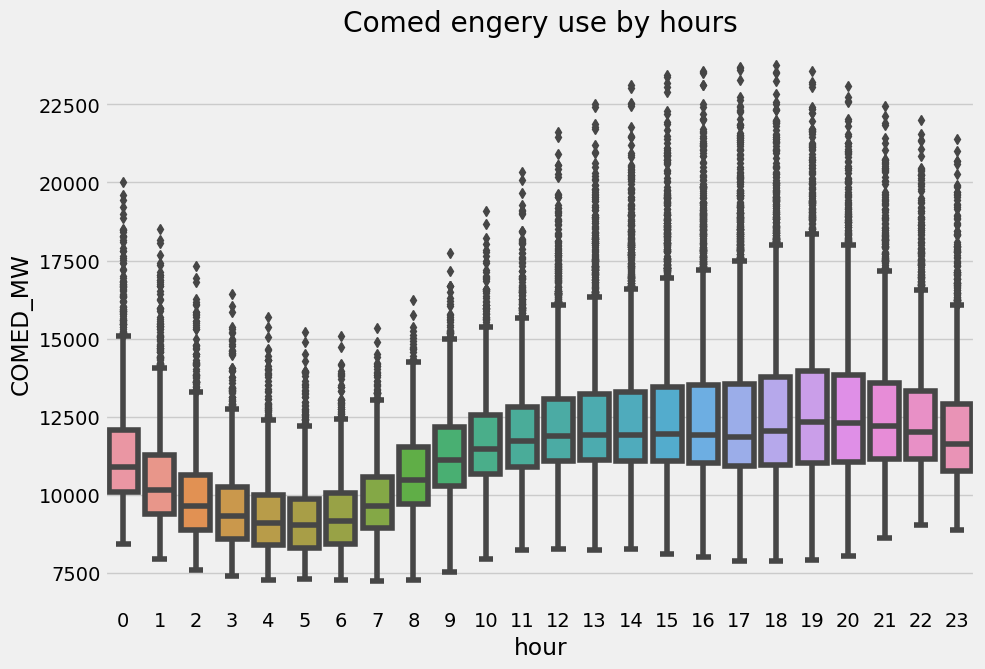

In [122]:
fig, ax = plt.subplots(figsize = (10,7))
sns.boxplot(data = df_new, x = 'hour', y = 'COMED_MW')
ax.set_title('Comed engery use by hours')
plt.show()

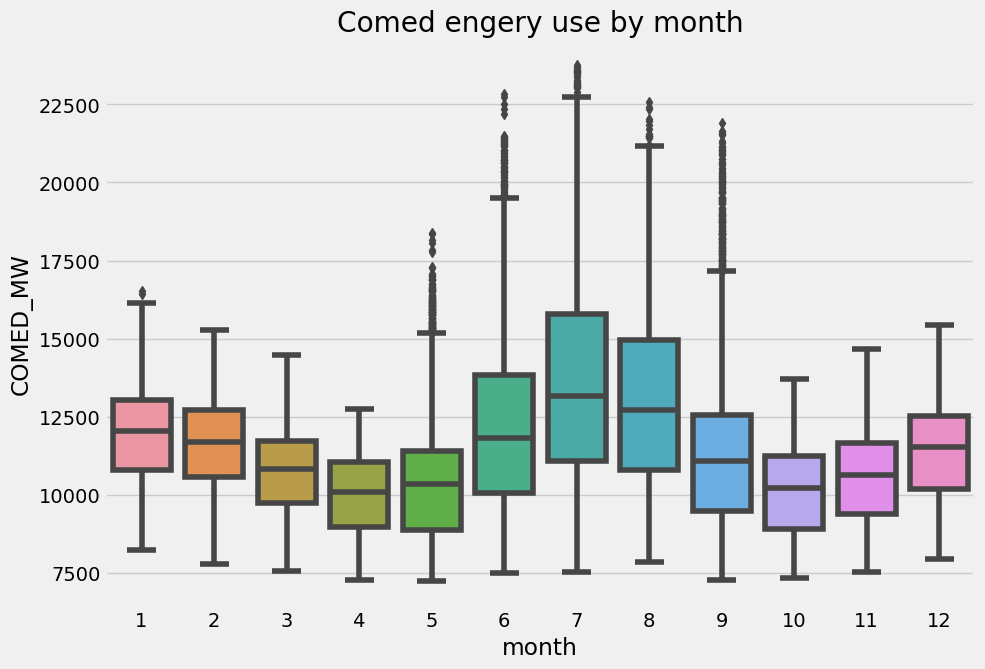

In [124]:
fig, ax = plt.subplots(figsize = (10,7))
sns.boxplot(data = df_new, x = 'month', y = 'COMED_MW')
ax.set_title('Comed engery use by month')
plt.show()

## Create Model

In [129]:
df_new.columns

Index(['COMED_MW', 'year', 'month', 'week_of_year', 'day_of_year',
       'day_of_month', 'day_of_week', 'hour'],
      dtype='object')

In [131]:
train = create_new_features(train)
test = create_new_features(test)
features = ['year', 'month', 'week_of_year', 'day_of_year','day_of_month', 'day_of_week', 'hour']
target_feature = 'COMED_MW'
X_train, X_test = train[features], test[features]
y_train, y_test = train[target_feature],test[target_feature]

In [137]:
xgb_reg_test = XGBRegressor(n_estimators = 1000,
                       # early_stopping = 50,
                       # max_depth = 5,
                       # objective='reg:linear',
                       # learning_rate = 0.05
                          )

In [ ]:
xgb_reg_test.fit(X_train, 
            y_train,
            eval_set = [(X_train, y_train),(X_test, y_test)],
            early_stopping_rounds = 50,
            verbose=True # if the test set didn't improve after 50 trees we make it verbose
           )